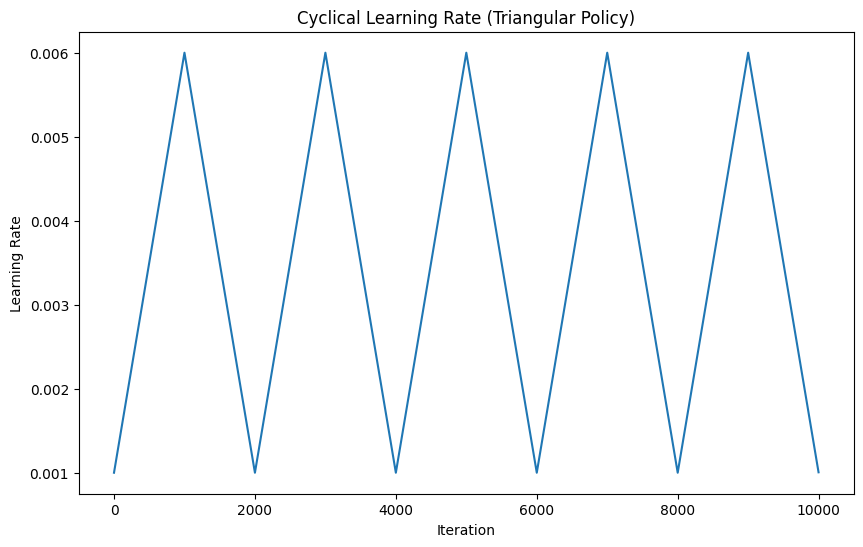

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def cyclic_lr(iteration, step_size, base_lr, max_lr):
    """Calculate the learning rate for a given iteration using the triangular policy.

    Args:
        iteration (int): The current iteration.
        step_size (int): The number of iterations in half a cycle.
        base_lr (float): The minimum learning rate (lower boundary).
        max_lr (float): The maximum learning rate (upper boundary).

    Returns:
        float: The calculated learning rate for the current iteration.
    """
    cycle = np.floor(1 + iteration / (2 * step_size))
    x = np.abs(iteration / step_size - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * np.maximum(0, (1 - x))
    return lr

# Example usage
iterations = 10000
step_size = 1000  # Half of the cycle length
base_lr = 0.001
max_lr = 0.006

lrs = [cyclic_lr(i, step_size, base_lr, max_lr) for i in range(iterations)]

plt.figure(figsize=(10, 6))
plt.plot(lrs)
plt.title('Cyclical Learning Rate (Triangular Policy)')
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_cnn_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))

    return model

# Create the model
model = create_cnn_model()

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_192 (Conv2D)         (None, 30, 30, 32)        896       
                                                                 
 conv2d_193 (Conv2D)         (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_96 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_144 (Dropout)       (None, 14, 14, 64)        0         
                                                                 
 conv2d_194 (Conv2D)         (None, 12, 12, 64)        36928     
                                                                 
 conv2d_195 (Conv2D)         (None, 10, 10, 64)        36928     
                                                     

In [ ]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
import numpy as np

class CyclicLR(Callback):
    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular'):
        super(CyclicLR, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.mode == 'triangular':
            return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x))

    def on_train_begin(self, logs=None):
        logs = logs or {}
        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Load and preprocess the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


In [ ]:

# Define the model (as previously defined)
model = create_cnn_model()

# Compile the model
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Initialize the CLR callback
clr = CyclicLR(base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular')

# Train the model
history = model.fit(x_train, y_train,
                    epochs=60, # Adjust epochs based on your requirements
                    batch_size=64,
                    validation_data=(x_test, y_test),
                    callbacks=[clr])


Epoch 1/60
782/782 [==============================] - 9s 9ms/step - loss: 1.5718 - accuracy: 0.4243 - val_loss: 1.2552 - val_accuracy: 0.5431
Epoch 2/60
393/782 [==============>...............] - ETA: 2s - loss: 1.2997 - accuracy: 0.5356

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import os


# Define the sequence of step sizes
step_sizes = [1, 0.1, 0.01, 0.001, 0.0001]

previous_best_model_path = None

for step_size in step_sizes:
    # Initialize the model
    model = create_cnn_model()

    # If there's a model from the previous step, load its weights
    if previous_best_model_path and os.path.exists(previous_best_model_path):
        model.load_weights(previous_best_model_path)
        print(f"Loaded weights from {previous_best_model_path}")

    # Compile the model with the current step size
    model.compile(optimizer=Adam(lr=step_size),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Define the checkpoint callback to save the best model
    checkpoint_filepath = f'best_model_step_size_{step_size}.h5'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max')

    # Train the model
    model.fit(x_train, y_train,
              epochs=5,
              batch_size=64,
              validation_data=(x_test, y_test),
              callbacks=[model_checkpoint_callback])

    # Update the path of the best model for the next iteration
    previous_best_model_path = checkpoint_filepath

    print(f"Training completed with step size {step_size}. Best model saved to {checkpoint_filepath}.")


Epoch 1/5
782/782 [==============================] - 9s 9ms/step - loss: 1.5654 - accuracy: 0.4237 - val_loss: 1.1996 - val_accuracy: 0.5694
Epoch 2/5
 15/782 [..............................] - ETA: 6s - loss: 1.2146 - accuracy: 0.5708

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


782/782 [==============================] - 7s 9ms/step - loss: 1.1519 - accuracy: 0.5895 - val_loss: 0.9713 - val_accuracy: 0.6605
Epoch 3/5
782/782 [==============================] - 7s 9ms/step - loss: 0.9878 - accuracy: 0.6478 - val_loss: 0.9025 - val_accuracy: 0.6837
Epoch 4/5
782/782 [==============================] - 7s 9ms/step - loss: 0.8826 - accuracy: 0.6898 - val_loss: 0.7981 - val_accuracy: 0.7192
Epoch 5/5
782/782 [==============================] - 7s 9ms/step - loss: 0.8155 - accuracy: 0.7139 - val_loss: 0.7976 - val_accuracy: 0.7214


Training completed with step size 1. Best model saved to best_model_step_size_1.h5.
Loaded weights from best_model_step_size_1.h5
Epoch 1/5
782/782 [==============================] - 9s 9ms/step - loss: 0.7578 - accuracy: 0.7329 - val_loss: 0.7208 - val_accuracy: 0.7487
Epoch 2/5
782/782 [==============================] - 7s 9ms/step - loss: 0.7214 - accuracy: 0.7437 - val_loss: 0.6980 - val_accuracy: 0.7545
Epoch 3/5
517/782 [==================>...........] - ETA: 2s - loss: 0.6845 - accuracy: 0.7576

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import os


# Define the sequence of step sizes
step_sizes = [1, 0.1, 0.01, 0.001, 0.0001]
epochs = [20,10,10,10,10]

previous_best_model_path = None

for i in range(len(step_sizes)):
    # Initialize the model
    step_size = step_sizes[i]
    epoch = epochs[i]
    model = create_cnn_model()

    # If there's a model from the previous step, load its weights
    if previous_best_model_path and os.path.exists(previous_best_model_path):
        model.load_weights(previous_best_model_path)
        print(f"Loaded weights from {previous_best_model_path}")

    # Compile the model with the current step size
    model.compile(optimizer=Adam(lr=step_size),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Define the checkpoint callback to save the best model
    checkpoint_filepath = f'best_model_step_size_{step_size}.h5'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max')

    # Train the model
    model.fit(x_train, y_train,
              epochs=epoch,
              batch_size=64,
              validation_data=(x_test, y_test),
              callbacks=[model_checkpoint_callback])

    # Update the path of the best model for the next iteration
    previous_best_model_path = checkpoint_filepath

    print(f"Training completed with step size {step_size}. Best model saved to {checkpoint_filepath}.")

Epoch 1/20
782/782 [==============================] - 9s 10ms/step - loss: 1.5924 - accuracy: 0.4156 - val_loss: 1.2823 - val_accuracy: 0.5326
Epoch 2/20
782/782 [==============================] - 7s 9ms/step - loss: 1.1620 - accuracy: 0.5856 - val_loss: 0.9985 - val_accuracy: 0.6464
Epoch 3/20
782/782 [==============================] - 7s 9ms/step - loss: 0.9733 - accuracy: 0.6576 - val_loss: 0.8676 - val_accuracy: 0.6966
Epoch 4/20
782/782 [==============================] - 7s 9ms/step - loss: 0.8678 - accuracy: 0.6944 - val_loss: 0.7890 - val_accuracy: 0.7229
Epoch 5/20
782/782 [==============================] - 7s 9ms/step - loss: 0.7968 - accuracy: 0.7202 - val_loss: 0.7179 - val_accuracy: 0.7502
Epoch 6/20
782/782 [==============================] - 7s 9ms/step - loss: 0.7432 - accuracy: 0.7390 - val_loss: 0.7352 - val_accuracy: 0.7470
Epoch 7/20
782/782 [==============================] - 7s 9ms/step - loss: 0.7057 - accuracy: 0.7522 - val_loss: 0.7189 - val_accuracy: 0.7480
Epoch

Training completed with step size 1. Best model saved to best_model_step_size_1.h5.
Loaded weights from best_model_step_size_1.h5
Epoch 1/10
782/782 [==============================] - 9s 10ms/step - loss: 0.4766 - accuracy: 0.8314 - val_loss: 0.6420 - val_accuracy: 0.7895
Epoch 2/10
782/782 [==============================] - 7s 9ms/step - loss: 0.4610 - accuracy: 0.8362 - val_loss: 0.6293 - val_accuracy: 0.7961
Epoch 3/10
782/782 [==============================] - 7s 9ms/step - loss: 0.4606 - accuracy: 0.8352 - val_loss: 0.6319 - val_accuracy: 0.7937
Epoch 4/10
782/782 [==============================] - 7s 9ms/step - loss: 0.4453 - accuracy: 0.8424 - val_loss: 0.6582 - val_accuracy: 0.7886
Epoch 5/10
782/782 [==============================] - 7s 9ms/step - loss: 0.4334 - accuracy: 0.8467 - val_loss: 0.6369 - val_accuracy: 0.7874
Epoch 6/10
782/782 [==============================] - 7s 9ms/step - loss: 0.4299 - accuracy: 0.8489 - val_loss: 0.6398 - val_accuracy: 0.7967
Epoch 7/10
782/78

Training completed with step size 0.1. Best model saved to best_model_step_size_0.1.h5.
Loaded weights from best_model_step_size_0.1.h5
Epoch 1/10
782/782 [==============================] - 9s 10ms/step - loss: 0.3957 - accuracy: 0.8597 - val_loss: 0.6440 - val_accuracy: 0.8006
Epoch 2/10
782/782 [==============================] - 7s 8ms/step - loss: 0.3899 - accuracy: 0.8612 - val_loss: 0.6394 - val_accuracy: 0.7992
Epoch 3/10
782/782 [==============================] - 7s 9ms/step - loss: 0.3819 - accuracy: 0.8620 - val_loss: 0.6815 - val_accuracy: 0.7882
Epoch 4/10
782/782 [==============================] - 7s 9ms/step - loss: 0.3851 - accuracy: 0.8631 - val_loss: 0.6313 - val_accuracy: 0.8013
Epoch 5/10
782/782 [==============================] - 7s 9ms/step - loss: 0.3787 - accuracy: 0.8659 - val_loss: 0.6566 - val_accuracy: 0.7972
Epoch 6/10
782/782 [==============================] - 7s 9ms/step - loss: 0.3715 - accuracy: 0.8678 - val_loss: 0.6591 - val_accuracy: 0.7924
Epoch 7/10


Training completed with step size 0.01. Best model saved to best_model_step_size_0.01.h5.
Loaded weights from best_model_step_size_0.01.h5
Epoch 1/10
782/782 [==============================] - 9s 9ms/step - loss: 0.3877 - accuracy: 0.8625 - val_loss: 0.6341 - val_accuracy: 0.8011
Epoch 2/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3770 - accuracy: 0.8655 - val_loss: 0.6470 - val_accuracy: 0.7961
Epoch 3/10
782/782 [==============================] - 7s 9ms/step - loss: 0.3685 - accuracy: 0.8698 - val_loss: 0.6230 - val_accuracy: 0.8024
Epoch 4/10
782/782 [==============================] - 7s 9ms/step - loss: 0.3669 - accuracy: 0.8700 - val_loss: 0.6502 - val_accuracy: 0.7933
Epoch 5/10
782/782 [==============================] - 7s 9ms/step - loss: 0.3599 - accuracy: 0.8726 - val_loss: 0.6789 - val_accuracy: 0.7974
Epoch 6/10
782/782 [==============================] - 7s 9ms/step - loss: 0.3550 - accuracy: 0.8750 - val_loss: 0.6416 - val_accuracy: 0.8032
Epoch 7/1

Training completed with step size 0.001. Best model saved to best_model_step_size_0.001.h5.
Loaded weights from best_model_step_size_0.001.h5
Epoch 1/10
782/782 [==============================] - 10s 9ms/step - loss: 0.3561 - accuracy: 0.8735 - val_loss: 0.6543 - val_accuracy: 0.7943
Epoch 2/10
782/782 [==============================] - 7s 9ms/step - loss: 0.3501 - accuracy: 0.8768 - val_loss: 0.6934 - val_accuracy: 0.7924
Epoch 3/10
782/782 [==============================] - 7s 9ms/step - loss: 0.3506 - accuracy: 0.8757 - val_loss: 0.6772 - val_accuracy: 0.8004
Epoch 4/10
782/782 [==============================] - 7s 9ms/step - loss: 0.3378 - accuracy: 0.8801 - val_loss: 0.6733 - val_accuracy: 0.7990
Epoch 5/10
782/782 [==============================] - 7s 9ms/step - loss: 0.3428 - accuracy: 0.8797 - val_loss: 0.6523 - val_accuracy: 0.8011
Epoch 6/10
782/782 [==============================] - 7s 8ms/step - loss: 0.3383 - accuracy: 0.8817 - val_loss: 0.6537 - val_accuracy: 0.8009
Epoch

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import load_model
import os


# Define the sequence of step sizes
step_sizes = [5,1, 0.1, 0.01, 0.001, 0.0001]
epochs = [5,20,10,10,10,10]

previous_best_model_path = None

for i in range(len(step_sizes)):
    # Initialize the model
    step_size = step_sizes[i]
    epoch = epochs[i]
    model = create_cnn_model()

    # If there's a model from the previous step, load its weights
    if previous_best_model_path and os.path.exists(previous_best_model_path):
        model.load_weights(previous_best_model_path)
        print(f"Loaded weights from {previous_best_model_path}")

    # Compile the model with the current step size
    model.compile(optimizer=SGD(lr=step_size),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Define the checkpoint callback to save the best model
    checkpoint_filepath = f'best_model_step_size_{step_size}.h5'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max')

    # Train the model
    model.fit(x_train, y_train,
              epochs=epoch,
              batch_size=64,
              validation_data=(x_test, y_test),
              callbacks=[model_checkpoint_callback])

    # Update the path of the best model for the next iteration
    previous_best_model_path = checkpoint_filepath

    print(f"Training completed with step size {step_size}. Best model saved to {checkpoint_filepath}.")

Epoch 1/5
782/782 [==============================] - 8s 9ms/step - loss: 2.2049 - accuracy: 0.1614 - val_loss: 2.3730 - val_accuracy: 0.1691
Epoch 2/5
782/782 [==============================] - 6s 8ms/step - loss: 1.9879 - accuracy: 0.2655 - val_loss: 1.8246 - val_accuracy: 0.3521
Epoch 3/5
782/782 [==============================] - 6s 8ms/step - loss: 1.8232 - accuracy: 0.3331 - val_loss: 1.8254 - val_accuracy: 0.3441
Epoch 4/5
782/782 [==============================] - 6s 8ms/step - loss: 1.7188 - accuracy: 0.3702 - val_loss: 1.5879 - val_accuracy: 0.4180
Epoch 5/5
782/782 [==============================] - 6s 8ms/step - loss: 1.6291 - accuracy: 0.4026 - val_loss: 1.5885 - val_accuracy: 0.4080


Training completed with step size 5. Best model saved to best_model_step_size_5.h5.
Loaded weights from best_model_step_size_5.h5
Epoch 1/20
782/782 [==============================] - 8s 9ms/step - loss: 1.6311 - accuracy: 0.4018 - val_loss: 1.7848 - val_accuracy: 0.3759
Epoch 2/20
782/782 [==============================] - 6s 8ms/step - loss: 1.5490 - accuracy: 0.4335 - val_loss: 1.4769 - val_accuracy: 0.4703
Epoch 3/20
782/782 [==============================] - 6s 8ms/step - loss: 1.4785 - accuracy: 0.4624 - val_loss: 1.3796 - val_accuracy: 0.5049
Epoch 4/20
782/782 [==============================] - 6s 8ms/step - loss: 1.4239 - accuracy: 0.4840 - val_loss: 1.4300 - val_accuracy: 0.4823
Epoch 5/20
782/782 [==============================] - 6s 8ms/step - loss: 1.3751 - accuracy: 0.5069 - val_loss: 1.2676 - val_accuracy: 0.5433
Epoch 6/20
782/782 [==============================] - 6s 8ms/step - loss: 1.3334 - accuracy: 0.5183 - val_loss: 1.2703 - val_accuracy: 0.5527
Epoch 7/20
782/782

Training completed with step size 1. Best model saved to best_model_step_size_1.h5.
Loaded weights from best_model_step_size_1.h5
Epoch 1/10
782/782 [==============================] - 8s 9ms/step - loss: 1.0115 - accuracy: 0.6426 - val_loss: 1.1563 - val_accuracy: 0.6000
Epoch 2/10
782/782 [==============================] - 6s 8ms/step - loss: 0.9944 - accuracy: 0.6496 - val_loss: 0.9304 - val_accuracy: 0.6735
Epoch 3/10
782/782 [==============================] - 6s 8ms/step - loss: 0.9748 - accuracy: 0.6567 - val_loss: 0.9375 - val_accuracy: 0.6666
Epoch 4/10
782/782 [==============================] - 6s 8ms/step - loss: 0.9581 - accuracy: 0.6613 - val_loss: 0.9447 - val_accuracy: 0.6646
Epoch 5/10
782/782 [==============================] - 6s 8ms/step - loss: 0.9426 - accuracy: 0.6669 - val_loss: 0.9601 - val_accuracy: 0.6621
Epoch 6/10
782/782 [==============================] - 6s 8ms/step - loss: 0.9316 - accuracy: 0.6694 - val_loss: 0.9519 - val_accuracy: 0.6605
Epoch 7/10
782/782

Training completed with step size 0.1. Best model saved to best_model_step_size_0.1.h5.
Loaded weights from best_model_step_size_0.1.h5
Epoch 1/10
782/782 [==============================] - 8s 9ms/step - loss: 0.8709 - accuracy: 0.6913 - val_loss: 1.0184 - val_accuracy: 0.6401
Epoch 2/10
782/782 [==============================] - 6s 8ms/step - loss: 0.8586 - accuracy: 0.6978 - val_loss: 0.8051 - val_accuracy: 0.7154
Epoch 3/10
782/782 [==============================] - 6s 8ms/step - loss: 0.8435 - accuracy: 0.7019 - val_loss: 0.8057 - val_accuracy: 0.7144
Epoch 4/10
782/782 [==============================] - 6s 8ms/step - loss: 0.8342 - accuracy: 0.7070 - val_loss: 0.8027 - val_accuracy: 0.7139
Epoch 5/10
782/782 [==============================] - 6s 8ms/step - loss: 0.8235 - accuracy: 0.7079 - val_loss: 0.7710 - val_accuracy: 0.7299
Epoch 6/10
782/782 [==============================] - 6s 8ms/step - loss: 0.8067 - accuracy: 0.7167 - val_loss: 0.8187 - val_accuracy: 0.7149
Epoch 7/10
7

Training completed with step size 0.01. Best model saved to best_model_step_size_0.01.h5.
Loaded weights from best_model_step_size_0.01.h5
Epoch 1/10
782/782 [==============================] - 8s 9ms/step - loss: 0.7709 - accuracy: 0.7288 - val_loss: 0.8312 - val_accuracy: 0.7106
Epoch 2/10
782/782 [==============================] - 6s 8ms/step - loss: 0.7577 - accuracy: 0.7318 - val_loss: 0.8539 - val_accuracy: 0.7019
Epoch 3/10
782/782 [==============================] - 6s 8ms/step - loss: 0.7488 - accuracy: 0.7374 - val_loss: 0.7523 - val_accuracy: 0.7360
Epoch 4/10
782/782 [==============================] - 6s 8ms/step - loss: 0.7399 - accuracy: 0.7393 - val_loss: 0.7697 - val_accuracy: 0.7309
Epoch 5/10
782/782 [==============================] - 6s 8ms/step - loss: 0.7316 - accuracy: 0.7395 - val_loss: 0.7230 - val_accuracy: 0.7476
Epoch 6/10
782/782 [==============================] - 6s 8ms/step - loss: 0.7199 - accuracy: 0.7476 - val_loss: 0.7230 - val_accuracy: 0.7420
Epoch 7/1

Training completed with step size 0.001. Best model saved to best_model_step_size_0.001.h5.
Loaded weights from best_model_step_size_0.001.h5
Epoch 1/10
782/782 [==============================] - 8s 9ms/step - loss: 0.6976 - accuracy: 0.7535 - val_loss: 0.9481 - val_accuracy: 0.6751
Epoch 2/10
782/782 [==============================] - 6s 8ms/step - loss: 0.6895 - accuracy: 0.7552 - val_loss: 0.6938 - val_accuracy: 0.7568
Epoch 3/10
782/782 [==============================] - 6s 8ms/step - loss: 0.6820 - accuracy: 0.7609 - val_loss: 0.7212 - val_accuracy: 0.7468
Epoch 4/10
782/782 [==============================] - 6s 8ms/step - loss: 0.6777 - accuracy: 0.7620 - val_loss: 0.6855 - val_accuracy: 0.7612
Epoch 5/10
782/782 [==============================] - 6s 8ms/step - loss: 0.6679 - accuracy: 0.7642 - val_loss: 0.7752 - val_accuracy: 0.7382
Epoch 6/10
782/782 [==============================] - 6s 8ms/step - loss: 0.6599 - accuracy: 0.7657 - val_loss: 0.6762 - val_accuracy: 0.7581
Epoch 

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import load_model
import os


# Define the sequence of step sizes
step_sizes = [5,1, 0.1, 0.01, 0.001, 0.0001]
epochs = [5,20,10,10,10,10]

previous_best_model_path = None

for i in range(len(step_sizes)):
    # Initialize the model
    step_size = step_sizes[i]
    epoch = epochs[i]
    model = create_cnn_model()

    # If there's a model from the previous step, load its weights
    if previous_best_model_path and os.path.exists(previous_best_model_path):
        model.load_weights(previous_best_model_path)
        print(f"Loaded weights from {previous_best_model_path}")

    # Compile the model with the current step size
    model.compile(optimizer=Adam(lr=step_size),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Define the checkpoint callback to save the best model
    checkpoint_filepath = f'best_model_step_size_{step_size}.h5'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max')

    # Train the model
    model.fit(x_train, y_train,
              epochs=epoch,
              batch_size=64,
              validation_data=(x_test, y_test),
              callbacks=[model_checkpoint_callback])

    # Update the path of the best model for the next iteration
    previous_best_model_path = checkpoint_filepath

    print(f"Training completed with step size {step_size}. Best model saved to {checkpoint_filepath}.")

Epoch 1/5
782/782 [==============================] - 9s 9ms/step - loss: 1.5687 - accuracy: 0.4271 - val_loss: 1.1948 - val_accuracy: 0.5671
Epoch 2/5
 15/782 [..............................] - ETA: 5s - loss: 1.2099 - accuracy: 0.5698

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


782/782 [==============================] - 6s 8ms/step - loss: 1.1628 - accuracy: 0.5867 - val_loss: 1.0344 - val_accuracy: 0.6383
Epoch 3/5
782/782 [==============================] - 6s 8ms/step - loss: 0.9873 - accuracy: 0.6554 - val_loss: 0.8620 - val_accuracy: 0.7019
Epoch 4/5
782/782 [==============================] - 6s 8ms/step - loss: 0.8890 - accuracy: 0.6876 - val_loss: 0.8004 - val_accuracy: 0.7194
Epoch 5/5
782/782 [==============================] - 6s 8ms/step - loss: 0.8214 - accuracy: 0.7129 - val_loss: 0.8100 - val_accuracy: 0.7241


Training completed with step size 5. Best model saved to best_model_step_size_5.h5.
Loaded weights from best_model_step_size_5.h5
Epoch 1/20
782/782 [==============================] - 9s 9ms/step - loss: 0.7692 - accuracy: 0.7293 - val_loss: 0.7241 - val_accuracy: 0.7488
Epoch 2/20
782/782 [==============================] - 6s 8ms/step - loss: 0.7248 - accuracy: 0.7440 - val_loss: 0.7017 - val_accuracy: 0.7577
Epoch 3/20
782/782 [==============================] - 6s 8ms/step - loss: 0.6924 - accuracy: 0.7582 - val_loss: 0.6971 - val_accuracy: 0.7620
Epoch 4/20
782/782 [==============================] - 6s 8ms/step - loss: 0.6608 - accuracy: 0.7667 - val_loss: 0.6846 - val_accuracy: 0.7635
Epoch 5/20
782/782 [==============================] - 6s 8ms/step - loss: 0.6258 - accuracy: 0.7804 - val_loss: 0.7072 - val_accuracy: 0.7588
Epoch 6/20
782/782 [==============================] - 6s 8ms/step - loss: 0.6097 - accuracy: 0.7843 - val_loss: 0.6563 - val_accuracy: 0.7799
Epoch 7/20
782/782

Training completed with step size 1. Best model saved to best_model_step_size_1.h5.
Loaded weights from best_model_step_size_1.h5
Epoch 1/10
782/782 [==============================] - 9s 9ms/step - loss: 0.4259 - accuracy: 0.8495 - val_loss: 0.6616 - val_accuracy: 0.7942
Epoch 2/10
782/782 [==============================] - 6s 8ms/step - loss: 0.4173 - accuracy: 0.8512 - val_loss: 0.6478 - val_accuracy: 0.7923
Epoch 3/10
782/782 [==============================] - 6s 8ms/step - loss: 0.4131 - accuracy: 0.8533 - val_loss: 0.6640 - val_accuracy: 0.7915
Epoch 4/10
782/782 [==============================] - 6s 8ms/step - loss: 0.4058 - accuracy: 0.8570 - val_loss: 0.6561 - val_accuracy: 0.7888
Epoch 5/10
782/782 [==============================] - 6s 8ms/step - loss: 0.4081 - accuracy: 0.8563 - val_loss: 0.6412 - val_accuracy: 0.7992
Epoch 6/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3984 - accuracy: 0.8601 - val_loss: 0.6385 - val_accuracy: 0.8021
Epoch 7/10
782/782

Training completed with step size 0.1. Best model saved to best_model_step_size_0.1.h5.
Loaded weights from best_model_step_size_0.1.h5
Epoch 1/10
782/782 [==============================] - 8s 9ms/step - loss: 0.3991 - accuracy: 0.8599 - val_loss: 0.6277 - val_accuracy: 0.8033
Epoch 2/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3882 - accuracy: 0.8639 - val_loss: 0.6297 - val_accuracy: 0.8047
Epoch 3/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3903 - accuracy: 0.8622 - val_loss: 0.6627 - val_accuracy: 0.7977
Epoch 4/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3791 - accuracy: 0.8676 - val_loss: 0.6665 - val_accuracy: 0.7984
Epoch 5/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3807 - accuracy: 0.8659 - val_loss: 0.6478 - val_accuracy: 0.7960
Epoch 6/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3725 - accuracy: 0.8683 - val_loss: 0.6608 - val_accuracy: 0.7999
Epoch 7/10
7

Training completed with step size 0.01. Best model saved to best_model_step_size_0.01.h5.
Loaded weights from best_model_step_size_0.01.h5
Epoch 1/10
782/782 [==============================] - 8s 9ms/step - loss: 0.3869 - accuracy: 0.8650 - val_loss: 0.6886 - val_accuracy: 0.7944
Epoch 2/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3799 - accuracy: 0.8664 - val_loss: 0.6824 - val_accuracy: 0.7939
Epoch 3/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3745 - accuracy: 0.8692 - val_loss: 0.6667 - val_accuracy: 0.7950
Epoch 4/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3787 - accuracy: 0.8660 - val_loss: 0.6464 - val_accuracy: 0.8002
Epoch 5/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3645 - accuracy: 0.8720 - val_loss: 0.6475 - val_accuracy: 0.8011
Epoch 6/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3667 - accuracy: 0.8704 - val_loss: 0.6713 - val_accuracy: 0.7918
Epoch 7/1

Training completed with step size 0.001. Best model saved to best_model_step_size_0.001.h5.
Loaded weights from best_model_step_size_0.001.h5
Epoch 1/10
782/782 [==============================] - 9s 9ms/step - loss: 0.3495 - accuracy: 0.8761 - val_loss: 0.6751 - val_accuracy: 0.8039
Epoch 2/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3451 - accuracy: 0.8792 - val_loss: 0.6874 - val_accuracy: 0.7946
Epoch 3/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3491 - accuracy: 0.8787 - val_loss: 0.6809 - val_accuracy: 0.7956
Epoch 4/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3476 - accuracy: 0.8806 - val_loss: 0.6852 - val_accuracy: 0.7981
Epoch 5/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3296 - accuracy: 0.8855 - val_loss: 0.7076 - val_accuracy: 0.7923
Epoch 6/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3339 - accuracy: 0.8846 - val_loss: 0.7075 - val_accuracy: 0.7975
Epoch 

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, AdamW
from tensorflow.keras.models import load_model
import os


# Define the sequence of step sizes
step_sizes = [5,1, 0.1, 0.01, 0.001, 0.0001]
epochs = [5,20,10,10,10,10]

previous_best_model_path = None

for i in range(len(step_sizes)):
    # Initialize the model
    step_size = step_sizes[i]
    epoch = epochs[i]
    model = create_cnn_model()

    # If there's a model from the previous step, load its weights
    if previous_best_model_path and os.path.exists(previous_best_model_path):
        model.load_weights(previous_best_model_path)
        print(f"Loaded weights from {previous_best_model_path}")

    # Compile the model with the current step size
    model.compile(optimizer=AdamW(lr=step_size),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Define the checkpoint callback to save the best model
    checkpoint_filepath = f'best_model_step_size_{step_size}.h5'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max')

    # Train the model
    model.fit(x_train, y_train,
              epochs=epoch,
              batch_size=64,
              validation_data=(x_test, y_test),
              callbacks=[model_checkpoint_callback])

    # Update the path of the best model for the next iteration
    previous_best_model_path = checkpoint_filepath

    print(f"Training completed with step size {step_size}. Best model saved to {checkpoint_filepath}.")

Epoch 1/5
782/782 [==============================] - 9s 9ms/step - loss: 1.5455 - accuracy: 0.4315 - val_loss: 1.2471 - val_accuracy: 0.5493
Epoch 2/5
 15/782 [..............................] - ETA: 5s - loss: 1.1797 - accuracy: 0.5740

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


782/782 [==============================] - 6s 8ms/step - loss: 1.1655 - accuracy: 0.5838 - val_loss: 0.9798 - val_accuracy: 0.6563
Epoch 3/5
782/782 [==============================] - 6s 8ms/step - loss: 0.9815 - accuracy: 0.6541 - val_loss: 0.9241 - val_accuracy: 0.6745
Epoch 4/5
782/782 [==============================] - 6s 8ms/step - loss: 0.8738 - accuracy: 0.6938 - val_loss: 0.8048 - val_accuracy: 0.7233
Epoch 5/5
782/782 [==============================] - 7s 8ms/step - loss: 0.8114 - accuracy: 0.7147 - val_loss: 0.7432 - val_accuracy: 0.7466


Training completed with step size 5. Best model saved to best_model_step_size_5.h5.
Loaded weights from best_model_step_size_5.h5
Epoch 1/20
782/782 [==============================] - 9s 9ms/step - loss: 0.7546 - accuracy: 0.7358 - val_loss: 0.7526 - val_accuracy: 0.7352
Epoch 2/20
782/782 [==============================] - 6s 8ms/step - loss: 0.7136 - accuracy: 0.7501 - val_loss: 0.7120 - val_accuracy: 0.7515
Epoch 3/20
782/782 [==============================] - 6s 8ms/step - loss: 0.6803 - accuracy: 0.7612 - val_loss: 0.6791 - val_accuracy: 0.7684
Epoch 4/20
782/782 [==============================] - 6s 8ms/step - loss: 0.6474 - accuracy: 0.7728 - val_loss: 0.6639 - val_accuracy: 0.7670
Epoch 5/20
782/782 [==============================] - 6s 8ms/step - loss: 0.6198 - accuracy: 0.7832 - val_loss: 0.6608 - val_accuracy: 0.7735
Epoch 6/20
782/782 [==============================] - 6s 8ms/step - loss: 0.5976 - accuracy: 0.7906 - val_loss: 0.6274 - val_accuracy: 0.7839
Epoch 7/20
782/782

Training completed with step size 1. Best model saved to best_model_step_size_1.h5.
Loaded weights from best_model_step_size_1.h5
Epoch 1/10
782/782 [==============================] - 9s 9ms/step - loss: 0.4264 - accuracy: 0.8487 - val_loss: 0.6078 - val_accuracy: 0.8070
Epoch 2/10
782/782 [==============================] - 6s 8ms/step - loss: 0.4163 - accuracy: 0.8534 - val_loss: 0.6339 - val_accuracy: 0.7967
Epoch 3/10
782/782 [==============================] - 6s 8ms/step - loss: 0.4164 - accuracy: 0.8527 - val_loss: 0.6542 - val_accuracy: 0.7962
Epoch 4/10
782/782 [==============================] - 6s 8ms/step - loss: 0.4064 - accuracy: 0.8549 - val_loss: 0.6263 - val_accuracy: 0.7949
Epoch 5/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3973 - accuracy: 0.8592 - val_loss: 0.6401 - val_accuracy: 0.8003
Epoch 6/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3872 - accuracy: 0.8621 - val_loss: 0.6378 - val_accuracy: 0.7952
Epoch 7/10
782/782

Training completed with step size 0.1. Best model saved to best_model_step_size_0.1.h5.
Loaded weights from best_model_step_size_0.1.h5
Epoch 1/10
782/782 [==============================] - 9s 9ms/step - loss: 0.3704 - accuracy: 0.8697 - val_loss: 0.6347 - val_accuracy: 0.8008
Epoch 2/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3720 - accuracy: 0.8679 - val_loss: 0.6244 - val_accuracy: 0.8028
Epoch 3/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3634 - accuracy: 0.8722 - val_loss: 0.6242 - val_accuracy: 0.8049
Epoch 4/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3609 - accuracy: 0.8728 - val_loss: 0.6441 - val_accuracy: 0.8031
Epoch 5/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3611 - accuracy: 0.8741 - val_loss: 0.6238 - val_accuracy: 0.8030
Epoch 6/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3493 - accuracy: 0.8768 - val_loss: 0.6083 - val_accuracy: 0.8080
Epoch 7/10
7

Training completed with step size 0.01. Best model saved to best_model_step_size_0.01.h5.
Loaded weights from best_model_step_size_0.01.h5
Epoch 1/10
782/782 [==============================] - 9s 9ms/step - loss: 0.3566 - accuracy: 0.8770 - val_loss: 0.6255 - val_accuracy: 0.8091
Epoch 2/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3423 - accuracy: 0.8798 - val_loss: 0.6303 - val_accuracy: 0.7997
Epoch 3/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3430 - accuracy: 0.8781 - val_loss: 0.6471 - val_accuracy: 0.8019
Epoch 4/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3377 - accuracy: 0.8804 - val_loss: 0.6689 - val_accuracy: 0.7968
Epoch 5/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3330 - accuracy: 0.8810 - val_loss: 0.6344 - val_accuracy: 0.8090
Epoch 6/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3395 - accuracy: 0.8801 - val_loss: 0.6378 - val_accuracy: 0.8043
Epoch 7/1

Training completed with step size 0.001. Best model saved to best_model_step_size_0.001.h5.
Loaded weights from best_model_step_size_0.001.h5
Epoch 1/10
782/782 [==============================] - 9s 9ms/step - loss: 0.3564 - accuracy: 0.8763 - val_loss: 0.6528 - val_accuracy: 0.7973
Epoch 2/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3432 - accuracy: 0.8783 - val_loss: 0.6250 - val_accuracy: 0.8067
Epoch 3/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3409 - accuracy: 0.8802 - val_loss: 0.6383 - val_accuracy: 0.8061
Epoch 4/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3385 - accuracy: 0.8807 - val_loss: 0.6342 - val_accuracy: 0.8088
Epoch 5/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3373 - accuracy: 0.8821 - val_loss: 0.6303 - val_accuracy: 0.7993
Epoch 6/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3250 - accuracy: 0.8849 - val_loss: 0.6336 - val_accuracy: 0.8100
Epoch 

In [ ]:
step_sizes = [10,5, 1, 0.1, 0.01, 0.001, 0.0001]
epochs = [5,10, 20, 10, 10, 10, 10]

previous_best_model_path = None
best_validation_accuracy = 0  # Track the best validation accuracy

for i in range(len(step_sizes)):
    step_size = step_sizes[i]
    epoch = epochs[i]
    model = create_cnn_model()  # Initialize the model

    # Load weights from the previous best model if it exists
    if previous_best_model_path and os.path.exists(previous_best_model_path):
        model.load_weights(previous_best_model_path)
        print(f"Loaded weights from {previous_best_model_path}")

    # Compile the model with the current step size
    model.compile(optimizer=AdamW(lr=step_size),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Define the checkpoint callback to save the best model for the current step size
    checkpoint_filepath = f'best_model_step_size_{step_size}.h5'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max')

    # Train the model
    model.fit(x_train, y_train,
              epochs=epoch,
              batch_size=64,
              validation_data=(x_test, y_test),
              callbacks=[model_checkpoint_callback])

    # Load the best model saved during the current training session to compare its performance
    current_best_model = load_model(checkpoint_filepath)
    val_loss, val_accuracy = current_best_model.evaluate(x_test, y_test)

    # Update the path of the best model if the current one is better
    if val_accuracy > best_validation_accuracy:
        best_validation_accuracy = val_accuracy
        previous_best_model_path = checkpoint_filepath
        print(f"New best model with validation accuracy {val_accuracy}, saved to {checkpoint_filepath}.")
    else:
        os.remove(checkpoint_filepath)  # Optionally remove the current checkpoint if it's not the best
        print(f"Training completed with step size {step_size}. Best model remains {previous_best_model_path} with validation accuracy {best_validation_accuracy}.")

Epoch 1/5
376/782 [=============>................] - ETA: 3s - loss: 1.7311 - accuracy: 0.3577

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import os


# Define the sequence of step sizes and epochs
step_sizes = [50,10,5, 1, 0.1, 0.01, 0.001, 0.0003,0.0001]
epochs = [5,5,10, 20, 10, 10, 10, 20, 20]

overall_best_model_path = 'overall_best_model.h5'  # Path for the overall best model
best_validation_accuracy = 0  # Track the best validation accuracy

for i in range(len(step_sizes)):
    step_size = step_sizes[i]
    epoch = epochs[i]
    model = create_cnn_model()  # Initialize the model

    # Load weights from the overall best model if it exists
    if os.path.exists(overall_best_model_path):
        model.load_weights(overall_best_model_path)
        print(f"Loaded weights from the overall best model")

    # Compile the model with the current step size
    model.compile(optimizer=Adam(lr=step_size),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Use a temporary checkpoint path for the current training session
    temp_checkpoint_filepath = 'temp_best_model.h5'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=temp_checkpoint_filepath,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max')

    # Train the model
    model.fit(x_train, y_train,
              epochs=epoch,
              batch_size=64,
              validation_data=(x_test, y_test),
              callbacks=[model_checkpoint_callback])

    # Load the temporarily saved model to compare its performance
    temp_best_model = load_model(temp_checkpoint_filepath)
    val_loss, val_accuracy = temp_best_model.evaluate(x_test, y_test)

    # If the temporary model is better, update the overall best model
    if val_accuracy > best_validation_accuracy:
        best_validation_accuracy = val_accuracy
        # Replace the overall best model with the new best
        os.rename(temp_checkpoint_filepath, overall_best_model_path)
        print(f"Updated the overall best model with validation accuracy {val_accuracy}.")
    else:
        # Delete the temporary model if it's not the best
        os.remove(temp_checkpoint_filepath)
        print(f"Step size {step_size} training completed. No update to the overall best model.")

# At the end, the overall_best_model_path points to the model with the highest validation accuracy across all step sizes.

Epoch 1/5
782/782 [==============================] - 8s 9ms/step - loss: 1.5915 - accuracy: 0.4118 - val_loss: 1.2195 - val_accuracy: 0.5654
Epoch 2/5
 15/782 [..............................] - ETA: 5s - loss: 1.2283 - accuracy: 0.5542

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


782/782 [==============================] - 6s 8ms/step - loss: 1.1613 - accuracy: 0.5874 - val_loss: 0.9990 - val_accuracy: 0.6454
Epoch 3/5
782/782 [==============================] - 6s 8ms/step - loss: 0.9903 - accuracy: 0.6510 - val_loss: 0.8752 - val_accuracy: 0.6889
Epoch 4/5
782/782 [==============================] - 6s 8ms/step - loss: 0.8824 - accuracy: 0.6901 - val_loss: 0.8282 - val_accuracy: 0.7087
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.7828 - accuracy: 0.7294
Updated the overall best model with validation accuracy 0.7293999791145325.


Loaded weights from the overall best model
Epoch 1/10
782/782 [==============================] - 8s 9ms/step - loss: 0.7508 - accuracy: 0.7378 - val_loss: 0.7150 - val_accuracy: 0.7485
Epoch 2/10
782/782 [==============================] - 6s 8ms/step - loss: 0.7154 - accuracy: 0.7470 - val_loss: 0.6900 - val_accuracy: 0.7609
Epoch 3/10
782/782 [==============================] - 6s 8ms/step - loss: 0.6796 - accuracy: 0.7620 - val_loss: 0.6818 - val_accuracy: 0.7677
Epoch 4/10
782/782 [==============================] - 6s 8ms/step - loss: 0.6446 - accuracy: 0.7719 - val_loss: 0.6773 - val_accuracy: 0.7714
Epoch 5/10
782/782 [==============================] - 6s 8ms/step - loss: 0.6114 - accuracy: 0.7842 - val_loss: 0.6949 - val_accuracy: 0.7635
Epoch 6/10
782/782 [==============================] - 6s 8ms/step - loss: 0.5910 - accuracy: 0.7919 - val_loss: 0.6569 - val_accuracy: 0.7771
Epoch 7/10
782/782 [==============================] - 6s 8ms/step - loss: 0.5638 - accuracy: 0.8013 - val

Loaded weights from the overall best model
Epoch 1/20
782/782 [==============================] - 8s 9ms/step - loss: 0.5513 - accuracy: 0.8045 - val_loss: 0.6438 - val_accuracy: 0.7857
Epoch 2/20
782/782 [==============================] - 6s 8ms/step - loss: 0.5302 - accuracy: 0.8126 - val_loss: 0.6432 - val_accuracy: 0.7786
Epoch 3/20
782/782 [==============================] - 6s 8ms/step - loss: 0.5120 - accuracy: 0.8193 - val_loss: 0.6282 - val_accuracy: 0.7877
Epoch 4/20
782/782 [==============================] - 6s 8ms/step - loss: 0.4951 - accuracy: 0.8239 - val_loss: 0.6248 - val_accuracy: 0.7890
Epoch 5/20
782/782 [==============================] - 6s 8ms/step - loss: 0.4871 - accuracy: 0.8263 - val_loss: 0.6206 - val_accuracy: 0.7942
Epoch 6/20
782/782 [==============================] - 6s 8ms/step - loss: 0.4702 - accuracy: 0.8330 - val_loss: 0.6365 - val_accuracy: 0.7883
Epoch 7/20
782/782 [==============================] - 6s 8ms/step - loss: 0.4670 - accuracy: 0.8349 - val

Loaded weights from the overall best model
Epoch 1/10
782/782 [==============================] - 8s 9ms/step - loss: 0.3726 - accuracy: 0.8674 - val_loss: 0.6522 - val_accuracy: 0.7960
Epoch 2/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3560 - accuracy: 0.8739 - val_loss: 0.6502 - val_accuracy: 0.7983
Epoch 3/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3665 - accuracy: 0.8699 - val_loss: 0.6505 - val_accuracy: 0.8041
Epoch 4/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3557 - accuracy: 0.8728 - val_loss: 0.6462 - val_accuracy: 0.7990
Epoch 5/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3544 - accuracy: 0.8734 - val_loss: 0.6563 - val_accuracy: 0.8005
Epoch 6/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3495 - accuracy: 0.8769 - val_loss: 0.6521 - val_accuracy: 0.7983
Epoch 7/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3438 - accuracy: 0.8785 - val

Loaded weights from the overall best model
Epoch 1/10
782/782 [==============================] - 8s 9ms/step - loss: 0.3607 - accuracy: 0.8732 - val_loss: 0.6419 - val_accuracy: 0.8028
Epoch 2/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3530 - accuracy: 0.8744 - val_loss: 0.6509 - val_accuracy: 0.8017
Epoch 3/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3507 - accuracy: 0.8765 - val_loss: 0.6702 - val_accuracy: 0.7998
Epoch 4/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3403 - accuracy: 0.8798 - val_loss: 0.6467 - val_accuracy: 0.7987
Epoch 5/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3457 - accuracy: 0.8786 - val_loss: 0.6705 - val_accuracy: 0.7949
Epoch 6/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3524 - accuracy: 0.8769 - val_loss: 0.6288 - val_accuracy: 0.8032
Epoch 7/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3394 - accuracy: 0.8813 - val

Loaded weights from the overall best model
Epoch 1/10
782/782 [==============================] - 8s 9ms/step - loss: 0.3618 - accuracy: 0.8714 - val_loss: 0.6272 - val_accuracy: 0.8070
Epoch 2/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3559 - accuracy: 0.8729 - val_loss: 0.6547 - val_accuracy: 0.7948
Epoch 3/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3515 - accuracy: 0.8763 - val_loss: 0.6631 - val_accuracy: 0.8013
Epoch 4/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3472 - accuracy: 0.8779 - val_loss: 0.6411 - val_accuracy: 0.8035
Epoch 5/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3454 - accuracy: 0.8787 - val_loss: 0.6579 - val_accuracy: 0.8004
Epoch 6/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3466 - accuracy: 0.8780 - val_loss: 0.6892 - val_accuracy: 0.7910
Epoch 7/10
782/782 [==============================] - 6s 8ms/step - loss: 0.3369 - accuracy: 0.8786 - val

Loaded weights from the overall best model
Epoch 1/20
782/782 [==============================] - 8s 9ms/step - loss: 0.3619 - accuracy: 0.8734 - val_loss: 0.6578 - val_accuracy: 0.7932
Epoch 2/20
782/782 [==============================] - 6s 8ms/step - loss: 0.3528 - accuracy: 0.8748 - val_loss: 0.6530 - val_accuracy: 0.7993
Epoch 3/20
782/782 [==============================] - 6s 8ms/step - loss: 0.3510 - accuracy: 0.8771 - val_loss: 0.6595 - val_accuracy: 0.7993
Epoch 4/20
782/782 [==============================] - 6s 8ms/step - loss: 0.3457 - accuracy: 0.8777 - val_loss: 0.6603 - val_accuracy: 0.7976
Epoch 5/20
782/782 [==============================] - 6s 8ms/step - loss: 0.3441 - accuracy: 0.8797 - val_loss: 0.6603 - val_accuracy: 0.7980
Epoch 6/20
782/782 [==============================] - 6s 8ms/step - loss: 0.3348 - accuracy: 0.8818 - val_loss: 0.6743 - val_accuracy: 0.7985
Epoch 7/20
782/782 [==============================] - 6s 8ms/step - loss: 0.3410 - accuracy: 0.8808 - val

Loaded weights from the overall best model
Epoch 1/20
782/782 [==============================] - 8s 9ms/step - loss: 0.3623 - accuracy: 0.8751 - val_loss: 0.6589 - val_accuracy: 0.7987
Epoch 2/20
782/782 [==============================] - 6s 8ms/step - loss: 0.3559 - accuracy: 0.8740 - val_loss: 0.6688 - val_accuracy: 0.8035
Epoch 3/20
782/782 [==============================] - 6s 8ms/step - loss: 0.3400 - accuracy: 0.8804 - val_loss: 0.6709 - val_accuracy: 0.7961
Epoch 4/20
782/782 [==============================] - 6s 8ms/step - loss: 0.3454 - accuracy: 0.8800 - val_loss: 0.6739 - val_accuracy: 0.7942
Epoch 5/20
782/782 [==============================] - 6s 8ms/step - loss: 0.3419 - accuracy: 0.8799 - val_loss: 0.6296 - val_accuracy: 0.8019
Epoch 6/20
782/782 [==============================] - 6s 8ms/step - loss: 0.3422 - accuracy: 0.8800 - val_loss: 0.6843 - val_accuracy: 0.7951
Epoch 7/20
782/782 [==============================] - 6s 8ms/step - loss: 0.3399 - accuracy: 0.8815 - val

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import os


# Define the sequence of step sizes and epochs
step_sizes = [50,10,5, 1, 0.1, 0.01, 0.001, 0.0003,0.0001]
epochs = [5,5,10, 20, 10, 10, 10, 20, 20]
sequence = [[5,4,3,2,1], [1,1,0.1,0.1,0.01], [1,0.1,0.01,0.01,0.01], [.1,.01,.001,.001,.001], [.001,.001,.0003,.0001,.0001]]

overall_best_model_path = 'overall_best_model.h5'  # Path for the overall best model
best_validation_accuracy = 0  # Track the best validation accuracy

for i in range(len(step_sizes)):
    step_size = step_sizes[i]
    epoch = epochs[i]
    model = create_cnn_model()  # Initialize the model

    # Load weights from the overall best model if it exists
    if os.path.exists(overall_best_model_path):
        model.load_weights(overall_best_model_path)
        print(f"Loaded weights from the overall best model")

    # Compile the model with the current step size
    model.compile(optimizer=Adam(lr=step_size),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Use a temporary checkpoint path for the current training session
    temp_checkpoint_filepath = 'temp_best_model.h5'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=temp_checkpoint_filepath,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max')

    # Train the model
    model.fit(x_train, y_train,
              epochs=epoch,
              batch_size=64,
              validation_data=(x_test, y_test),
              callbacks=[model_checkpoint_callback])

    # Load the temporarily saved model to compare its performance
    temp_best_model = load_model(temp_checkpoint_filepath)
    val_loss, val_accuracy = temp_best_model.evaluate(x_test, y_test)

    # If the temporary model is better, update the overall best model
    if val_accuracy > best_validation_accuracy:
        best_validation_accuracy = val_accuracy
        # Replace the overall best model with the new best
        os.rename(temp_checkpoint_filepath, overall_best_model_path)
        print(f"Updated the overall best model with validation accuracy {val_accuracy}.")
    else:
        # Delete the temporary model if it's not the best
        os.remove(temp_checkpoint_filepath)
        print(f"Step size {step_size} training completed. No update to the overall best model.")